This notebook template is designed for testing the performance of Rotatron environments and different solving agents of different scales.

In [1]:
# =============================================================================
# Work on local biobuild in GIT repo
# =============================================================================
import os, sys, importlib

# for inside python scripts
# base = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(__file__))))
base = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(0, base)

def reload_optimizers():
    importlib.reload(bam.optimizers.environments)
    importlib.reload(bam.optimizers.agents)
# =============================================================================
import files
import auxiliary
import buildamol as bam
import buildamol.optimizers.environments as envs
import buildamol.optimizers.agents as agents
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go 
from collections import defaultdict

import time
import numpy as np
import pandas as pd

Here we can select which tests to run and on what testing structures:

In [2]:
# which structures to run on
structures_to_run_on = [
    # files.GLUCOSE2,
    # files.PEPTIDE,
    files.X_WING,
    # files.X_WING2,
    # files.SCAFFOLD1,
    # files.SCAFFOLD3,
]

# how many times to independently run on each structure
re_runs = 1

# visualize evaluation history
visualize_eval_history = True

# visualize time history
visualize_time_history = True

# visualise clashes in final structure
visualize_clashes = True

# clash threshold
clash_cutoff = 0.8

# visualize the final structure
visualize_final_structure = False

# visualization parameters
# for draw_edges()
visualization_params = dict(color="magenta", opacity=0.3)

# export visualization to html
export_visualization = False

# export solutions as PDB
export_pdb = True

# export history to csv
export_history = True

# export name prefix
export_name_prefix = None

# graph building function
# provide a custom callable that generates a tuple of (graph, rotatable_edges)
def make_graph(structure:bam.Molecule):
    graph = structure.get_atom_graph()
    # graph = structure.make_residue_graph()
    # graph.make_detailed(n_samples=0.5)
    edges = graph.find_rotatable_edges(min_descendants=20, min_ancestors=20)
    edges = graph.direct_edges(root_node=structure.get_atom("Cl1"), edges=edges, adopt=True)
    return graph, edges

graph_factory = make_graph

# graph building parameters
graph_params = {}

# provide a custom callable to set a custom building function for the environment
rotatron_factory = None

# the rotatron class to use
rotatron_class = envs.DistanceRotatron

# rotatron parameters
rotatron_params = {"pushback": 4, "radius": -1}

# the agent function to use
# agent = agents.nelder_mead_optimize
# agent_params = {}
agent = agents.swarm_optimize
agent_params = {"max_steps":10, "n_particles":10, "variation" : 0.2}#{"bounds":(-np.pi/2, np.pi/2)}

# agent = agents.newton_like_optimize

# # agent parameters
# agent_params = {"max_steps" : 300}   


Perform some environment setup

In [3]:
if agent is None:
    raise ValueError("No agent provided")
if rotatron_class is None:
    raise ValueError("No rotatron class provided")
    
if graph_factory is None:
    graph_factory = auxiliary.graph_factory
if rotatron_factory is None:
    rotatron_factory = auxiliary.rotatron_factory

available_structures = {}

eval_history = defaultdict(list)
time_history = defaultdict(list)
clash_history = defaultdict(list)
final_visuals = {}
initial_evals = {}
initial_clashes = {}
v = None

if not export_name_prefix:
    export_name_prefix = rotatron_class.__name__ + "." + agent.__name__

def make_environment(structure):
    """
    An environment generator
    """
    graph, rotatable_edges = graph_factory(structure, **graph_params)
    return rotatron_factory(rotatron_class, graph, rotatable_edges, **rotatron_params)


Now start the main testing code

In [4]:
structure = bam.molecule(structures_to_run_on[0])

In [5]:
# structure.rotate_descendants(10, 24, 50)
structure.show()

In [6]:
g = structure.make_residue_graph()
g.make_detailed()
g.show()

In [24]:
clashes = structure.find_clashes()

edges = env.rotatable_edges
edge_coords = np.array([(e[0].coord + e[1].coord)/2 for e in edges])
clash_edges = []
for clash in clashes:
    coord1, coord2 = clash[0].coord, clash[1].coord
    clash_edges.append(
        np.argmin(np.linalg.norm(edge_coords - coord1, axis=1))
    )
    # clash_edges.append(
    #     np.argmin(np.linalg.norm(edge_coords - coord2, axis=1))
    # )
clash_edges = np.unique(clash_edges)
clash_edges = np.array(edges)[clash_edges]


In [25]:
clash_edges

array([[Atom(C4, 68), Atom(C3, 65)]], dtype=object)

In [39]:
ex7 = bam.molecule(files.X_WING2)

In [58]:
def declash(structure, graph=None, edges=None, _copy:bool=True, rotatron=envs.DistanceRotatron, agent=agents.scipy_optimize, rotatron_params=None, agent_params=None):
    if not graph:
        graph = structure.make_residue_graph()
        graph.make_detailed()
    if not edges:
        edges = graph.find_rotatable_edges(min_descendants=3, min_ancestors=3)

    rotatron_params = rotatron_params or {}
    agent_params = agent_params or {}

    s = structure.copy() if _copy else structure
    
    clashes = s.find_clashes()
    steps = 0
    while len(clashes) > 0 and steps < 2:
        print("round", steps, "clashes", len(clashes))
        clash_edges = []
        edge_coords = np.array([(e[0].coord + e[1].coord)/2 for e in edges])
        for clash in clashes:
            coord1 = clash[0].coord
            edge_candidates = np.linalg.norm(edge_coords - coord1, axis=1) < 10
            edge_candidates = np.where(edge_candidates)[0]
            clash_edges.extend(
                edges[i] for i in edge_candidates
            )

        clash_edges = np.unique(clash_edges)
        print(clash_edges)
        return

        #     env = rotatron(graph, [clash_edge], **rotatron_params)
        #     sol, eval = agent(env, **agent_params)
        #     final = auxiliary.apply_solution(sol, env, s)
        #     _clashes = final.find_clashes()
        #     if len(_clashes) < len(clashes):
        #         s = final
        # clashes = s.find_clashes()
        # steps += 1


    return final, sol, eval


final, sol, eval = declash(ex7, graph=ex7._AtomGraph, rotatron_params={"radius":20})
final.show()


round 0 clashes 4
[Atom(C8, 6) Atom(C7, 14) Atom(CA, 33) Atom(C, 34) Atom(N, 32) Atom(C, 34)
 Atom(CB, 36) Atom(OG, 37) Atom(OXT, 38) Atom(O3, 43) Atom(C3, 45)
 Atom(C1, 49) Atom(OG, 37) Atom(OXT, 38) Atom(O3, 43) Atom(C2, 50)
 Atom(N20, 62) Atom(C3, 65) Atom(C1, 67) Atom(C4, 68) Atom(C5, 69)
 Atom(O2, 77) Atom(N12, 79) Atom(C2, 80) Atom(C1, 81) Atom(C4, 88)
 Atom(C8, 89) Atom(C7, 97) Atom(CA, 116) Atom(C, 117) Atom(CB, 119)
 Atom(N, 32) Atom(OG, 37) Atom(OXT, 38) Atom(O3, 43) Atom(C2, 80)
 Atom(C1, 81) Atom(C8, 89) Atom(C7, 97) Atom(CA, 116) Atom(C, 117)
 Atom(O3, 43) Atom(C, 117) Atom(CB, 119) Atom(N20, 62) Atom(O2, 77)
 Atom(N12, 79) Atom(N, 115) Atom(CB, 119) Atom(C1, 132) Atom(C2, 133)
 Atom(OG, 120) Atom(C3, 128) Atom(OG, 120) Atom(OXT, 121) Atom(C1, 132)
 Atom(C2, 133) Atom(C3, 148) Atom(OXT, 121) Atom(O3, 126) Atom(C3, 128)
 Atom(C1, 132) Atom(C2, 133) Atom(N20, 145) Atom(C3, 148) Atom(C1, 150)
 Atom(C4, 151) Atom(N20, 145) Atom(C4, 151) Atom(O3, 126) Atom(C5, 152)
 Atom(C1, 16

TypeError: cannot unpack non-iterable NoneType object

In [35]:
final.find_clashes()

[]

In [13]:
# def eval(self, state):  # , diff=True):
#         """
#         Calculate the evaluation score for a given state

#         Parameters
#         ----------
#         state : np.ndarray
#             The state of the environment

#         Returns
#         -------
#         float
#             The evaluation for the state
#         """
#         pairwise_dists = cdist(state, state)
#         np.fill_diagonal(pairwise_dists, self._radius + 1)

#         # if diff:
#         # mask = np.abs(pairwise_dists - self._state_dists) < 1e-4
#         # mask *= pairwise_dists > self.clash_distance
#         # pairwise_dists[mask] = self._radius + 1

#         # self.clash_handler()

#         rowwise_dist_eval = np.apply_along_axis(
#             self.concatenation_function, 1, pairwise_dists
#         )
#         mask = rowwise_dist_eval > -1
#         rowwise_dist_eval[mask] = self.n_nodes / (
#             (rowwise_dist_eval[mask] + 1e-6)
#         ) 
#         rowwise_dist_eval[mask] = np.log(rowwise_dist_eval[mask])
#         if np.any(mask) == 1:
#             final = np.sum(rowwise_dist_eval[mask])
#             self._state_dists[:, :] = 0
#             self._state_dists += pairwise_dists
#         else:
#             final = self._last_eval
#         return final

# envs.DistanceRotatron.eval = eval


Text(0.5, 1.0, 'Evaluation function')

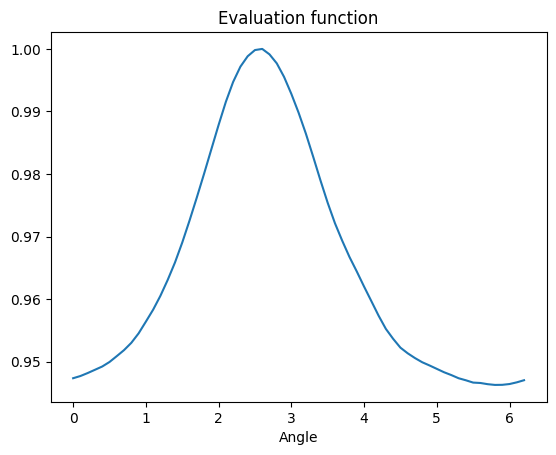

In [14]:

angles = np.arange(0, np.pi*2, 0.1)

env = envs.DistanceRotatron(graph, edges, radius=15, mask_rotation_units=True)

evals = np.zeros_like(angles)

idx = 0
for angle in angles:
    state, eval, *_ = env.step([angle])
    evals[idx] = eval
    env.reset()
    idx += 1
evals /= evals.max()
ax = sns.lineplot(x=angles, y=evals)
ax.set_xlabel("Angle")
ax.set_title("Evaluation function")


In [15]:
env = envs.DistanceRotatron(graph, edges)

animation_frames = []
evals = np.zeros_like(angles)

idx = 0
for angle in angles:
    state, eval, *_ = env.step([angle])
    evals[idx] = eval
    env.reset()
    idx += 1

_e = -evals + evals.max()
_e = _e / _e.max()
for i, angle in enumerate(angles):
    v = env.graph.draw()
    s = structure.copy()
    s.rotate_descendants(32, 33, angle, angle_is_degrees=False)
    v.draw_edges(*s.bonds, color="blue", opacity = _e[i] ) 
    animation_frames.append(go.Frame(data=v.figure.data))

angle = angles[np.argmin(evals)]
s = structure.copy()
s.rotate_descendants(32, 33, angle, angle_is_degrees=False)
v.draw_edges(*s.bonds, color="green", opacity = 1)

animation_frames.append(go.Frame(data=v.figure.data))
v.show()

anim = go.Figure(
    data=v.figure.data,
    layout=v.figure.layout,
    frames=animation_frames,
)
anim.write_html("animation.html")

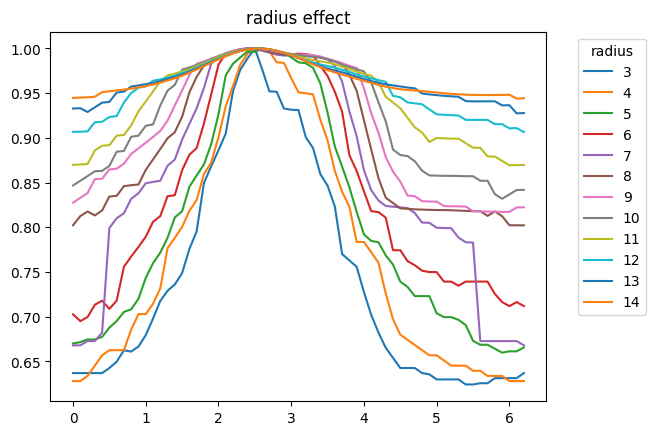

In [16]:

angles = np.arange(0, np.pi*2, 0.1)

for radius in range(3, 15, 1):
    env = envs.DistanceRotatron(graph, edges, radius=radius)
    
    evals = np.zeros_like(angles)

    idx = 0
    for angle in angles:
        state, eval, *_ = env.step([angle])
        evals[idx] = eval
        env.reset()
        idx += 1
    evals /= evals.max()
    ax = sns.lineplot(x=angles, y=evals, label=radius)
    ax.legend(bbox_to_anchor=(1.05, 1)).set_title("radius")
    ax.set_title("radius effect")


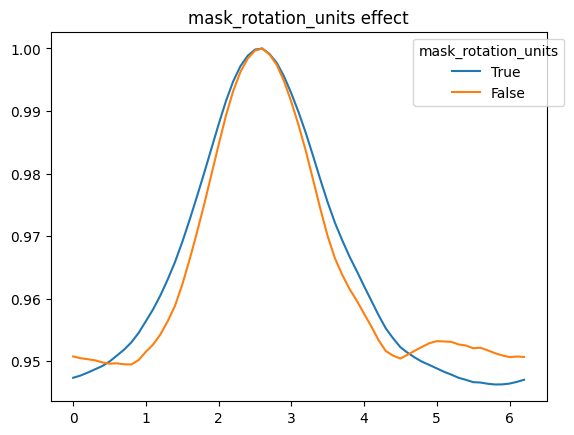

In [17]:
for i in (True, False):
    env = envs.DistanceRotatron(graph, edges, mask_rotation_units=i, radius=15)

    evals = np.zeros_like(angles)

    idx = 0
    for angle in angles:
        state, eval, *_ = env.step([angle])
        evals[idx] = eval
        env.reset()
        idx += 1

    evals /= evals.max()
    ax = sns.lineplot(x=angles, y=evals, label=i)
    ax.legend(bbox_to_anchor=(1.05, 1)).set_title("mask_rotation_units")
    ax.set_title("mask_rotation_units effect")